In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
%matplotlib inline
from sklearn import preprocessing

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

In [67]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

combine = [train, test]
for df in combine:
    print (df.info())
    print ('-'*50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket      

   ###### Discrete: PassengerId, Age, SibSp, Parch
   ###### Continous: Fare
   ###### Categorical: Embarked
   ###### Ordinal: Pclass
   ###### Mixture: Cabin, Ticket

In [68]:
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [69]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [71]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Slemen, Mr. Richard James",male,1601,G6,S
freq,1,577,7,4,644


##### Female/Single people has higher survival rate

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

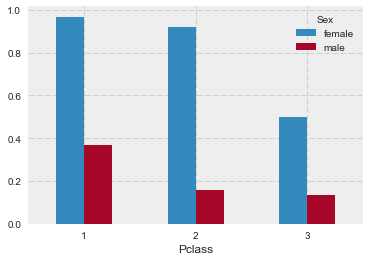

In [51]:
train.pivot_table(values='Survived', columns='Sex', index=['Pclass'], aggfunc='mean').plot(kind='bar')
plt.xticks(rotation='0')

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

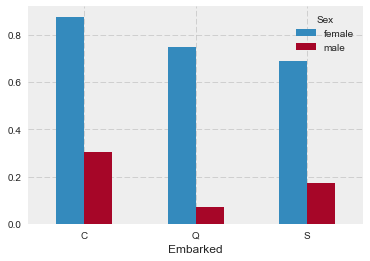

In [52]:
train.pivot_table(values='Survived', columns='Sex', index=['Embarked'], aggfunc='mean').plot(kind='bar')
plt.xticks(rotation='0')

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

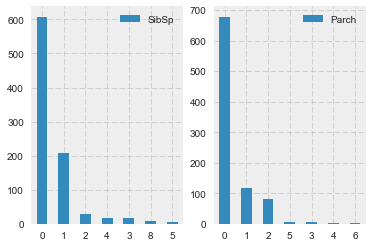

In [54]:
plt.subplot2grid((1, 2), (0, 0))
train['SibSp'].value_counts().plot(kind='bar').legend()
plt.xticks(rotation='0')

plt.subplot2grid((1, 2), (0, 1))
train['Parch'].value_counts().plot(kind='bar').legend()
plt.xticks(rotation='0')

## Modifying Features

#### Adding new feature 'Family Size'

In [74]:
for df in combine:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
train['FamilySize'].value_counts()

1     537
2     161
3     102
4      29
6      22
5      15
7      12
11      7
8       6
Name: FamilySize, dtype: int64

#### Adding new feature 'Alone'

In [75]:
for df in combine:
    df['Alone'] = 0
    df.loc[df['FamilySize'] == 1, 'Alone'] = 1
    
train['Alone'].value_counts()

1    537
0    354
Name: Alone, dtype: int64

#### Filling missing values for 'Embarked'

In [76]:
for df in combine:
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
    
train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

#### 'Fare': Filling missing values, grouping values

In [77]:
for df in combine:
    df['Fare'].fillna(df['Fare'].median(), inplace=True)
    
    df.loc[df['Fare'] <= 10.5, 'Fare'] = 0
    df.loc[(df['Fare'] > 10.5) & (df['Fare'] <= 21.679), 'Fare'] = 1
    df.loc[(df['Fare'] > 21.679) & (df['Fare'] <= 39.688), 'Fare'] = 2
    df.loc[(df['Fare'] > 39.688) & (df['Fare'] <= 512.329), 'Fare'] = 3
    df.loc[df['Fare'] > 512.329, 'Fare'] = 4 
    
train[['Fare', 'Survived']].groupby('Fare', as_index=False).mean()

,Fare,Survived
0,0.0,0.209366
1,1.0,0.426901
2,2.0,0.441989
3,3.0,0.635838
4,4.0,1.000000


####  'Age': Filling missing values, grouping values

In [78]:
for df in combine:
    avg = df['Age'].mean()
    std = df['Age'].std()
    NaN_count = df['Age'].isnull().sum()
    
    age_fill = np.random.randint(avg-std, avg+std, NaN_count)
    df.loc[df['Age'].isnull(), 'Age'] = age_fill
    df['Age'] = df['Age'].astype(int)
    
    df.loc[df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 32), 'Age'] = 1
    df.loc[(df['Age'] > 32) & (df['Age'] <= 48), 'Age'] = 2
    df.loc[(df['Age'] > 48) & (df['Age'] <= 64), 'Age'] = 3
    df.loc[df['Age'] > 64, 'Age'] = 4
    
train[['Age', 'Survived']].groupby('Age').mean()

,Survived
Age,
0,0.508929
1,0.360987
2,0.367589
3,0.434783
4,0.090909


#### 'Name': Extracting titles

In [79]:
import re

def only_title(name):
    title = re.findall(' ([A-Za-z]+)\.', name)
    if title:
        return title[0]

for df in combine:
    df['Title'] = df['Name'].apply(only_title)
    
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Jonkheer      1
Don           1
Ms            1
Lady          1
Countess      1
Mme           1
Sir           1
Capt          1
Name: Title, dtype: int64

In [80]:
for df in combine:
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 
                                     'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby('Title', as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


### Data Encoding

In [81]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Alone,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,1,1,0,A/5 21171,0.0,NaN,S,2,0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,2,1,0,PC 17599,3.0,C85,C,2,0,Mrs


In [82]:
feature_drop = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'FamilySize']

for df in combine:
    df.drop(feature_drop, axis=1, inplace=True)

train.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Alone,Title
0,0,3,male,1,0.0,S,0,Mr
1,1,1,female,2,3.0,C,0,Mrs


In [83]:
def encode_features(train, test):
    features = ['Sex', 'Embarked', 'Fare', 'Age', 'Title']
    df_combined = pd.concat([train[features], test[features]])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        train[feature] = le.transform(train[feature])
        test[feature] = le.transform(test[feature])
    return train, test
    
train, test = encode_features(train, test)
train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Alone,Title
0,0,3,1,1,0,2,0,2
1,1,1,0,2,3,0,0,3
2,1,3,0,1,0,2,1,1
3,1,1,0,2,3,2,0,3
4,0,3,1,2,0,2,1,2


#### Feature heatmap

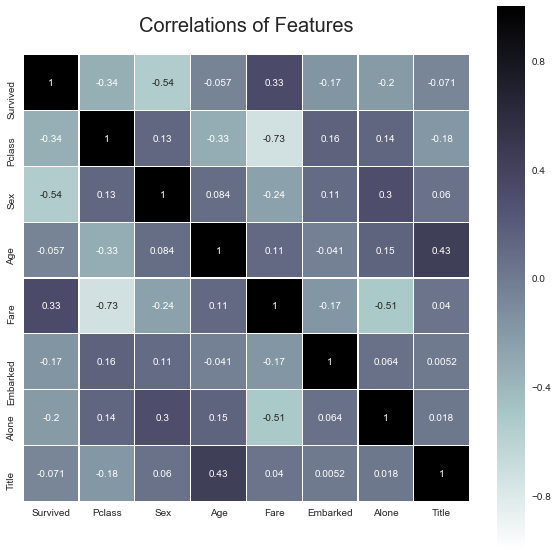

In [84]:
colormap = plt.cm.bone_r
plt.figure(figsize=(10,10))
plt.title('Correlations of Features', y=1.04, size=20)
sns.heatmap(train.astype(float).corr(), square=True, cmap=colormap, annot=True, linewidth=0.2)

## Train Models

In [85]:
X = train.drop(['Survived'], axis=1)
y = train['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=2017)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('Null Accuracy for y_test dataset:', y_test.value_counts()[1]/len(y_test))

X_train (712, 7)
X_test (179, 7)
y_train (712,)
y_test (179,)
Null Accuracy for y_test dataset: 0.296089385475


In [86]:
# Accuracy on Test data
def model_accuracy(model):
    model_y_pred_class = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, model_y_pred_class)
    return acc

# Cross_val_score on Test data
def mean_cv_score(model):
    cv_scores = cross_val_score(model, X_test, y_test, cv=10, scoring='accuracy')
    mean_score = cv_scores.mean()
    return mean_score

# AUC score on Test data
def auc_score(model):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    auc = metrics.roc_auc_score(y_test, y_pred_prob)
    return auc

# Confusion Matrix on Test data
def confusion_matrix(model):
    model_y_pred_class = model.predict(X_test)
    c_m = metrics.confusion_matrix(y_test, model_y_pred_class)
    return c_m

# Sensitivity
def sensitivity(model):
    model_y_pred_class = model.predict(X_test)
    sen = metrics.recall_score(y_test, model_y_pred_class)
    return sen

# Accuracy + cv_score + AUC score
def performance(model):
    print('Accuracy:', model_accuracy(model), '| 10_CV_Scores:', mean_cv_score(model), '| AUC score:', auc_score(model))

### 1. SVM

In [87]:
svc = SVC(probability=True)
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001, 'auto'], 'kernel': ['rbf']},
 ]
grid = GridSearchCV(svc, param_grid, cv=10)
svc.fit(X_train, y_train)
print(performance(svc), '\n', confusion_matrix(svc))

Accuracy: 0.837988826816 | 10_CV_Scores: 0.821224630203 | AUC score: 0.888814016173
None 
 [[108  18]
 [ 11  42]]


### 2. Logistic regression

In [89]:
logreg = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid = GridSearchCV(logreg, param_grid, cv=10)
grid_fit = grid.fit(X_train, y_train)
logreg = grid_fit.best_estimator_
logreg.fit(X_train, y_train)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [90]:
print(performance(logreg), '\n', confusion_matrix(logreg))

Accuracy: 0.821229050279 | 10_CV_Scores: 0.834193326453 | AUC score: 0.885669362084
None 
 [[108  18]
 [ 14  39]]


### 3. Random Forest

In [91]:
rf = RandomForestClassifier()
parameters = {'n_estimators': [10, 20, 30, 40], 'max_features':['auto', 'sqrt', None],  
              'criterion':['gini', 'entropy'], }
grid = GridSearchCV(rf, param_grid=parameters, cv=10, n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)
rf = grid_fit.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [92]:
print(performance(rf), '\n', confusion_matrix(rf))

Accuracy: 0.837988826816 | 10_CV_Scores: 0.828637770898 | AUC score: 0.880877508236
None 
 [[111  15]
 [ 14  39]]


### 4. KNN

In [96]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors':list(range(1,15)), 'weights':['distance', 'uniform']}
grid = GridSearchCV(knn, param_grid, cv=10, n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)
knn = grid_fit.best_estimator_
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='distance')

In [97]:
print(performance(knn), '\n', confusion_matrix(knn))

Accuracy: 0.815642458101 | 10_CV_Scores: 0.789060887513 | AUC score: 0.848682240192
None 
 [[109  17]
 [ 16  37]]


### 5. Extra Trees

In [98]:
et = RandomForestClassifier()
parameters = {'n_estimators': [10, 20, 30, 40, 50], 'max_features':['auto', 'sqrt', None], 
              'criterion':['gini', 'entropy']}
grid = GridSearchCV(et, param_grid=parameters, cv=10, n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)
et = grid_fit.best_estimator_
et.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [99]:
print(performance(et), '\n', confusion_matrix(et))

Accuracy: 0.837988826816 | 10_CV_Scores: 0.811609907121 | AUC score: 0.87189278227
None 
 [[111  15]
 [ 14  39]]


### 6. Gradient Boosting

In [102]:
gb = GradientBoostingClassifier(n_estimators=120, max_features='sqrt')
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=120, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [103]:
print(performance(gb), '\n', confusion_matrix(gb))

Accuracy: 0.837988826816 | 10_CV_Scores: 0.827399380805 | AUC score: 0.898397723869
None 
 [[110  16]
 [ 13  40]]


### Models Comparisons

In [104]:
models = [svc, logreg, rf, knn, et, gb]
model_names = ['Support Vector Machine', 'Logistic Regression', 'Random Forest', 'K-Nearest', 'Extra Trees', 'Gradient Boost']
model_dict = dict(zip(model_names, models))

In [105]:
[print(item, 'accuracy:', model_accuracy(model_dict[item])) for item in model_dict]

Support Vector Machine accuracy: 0.837988826816
Logistic Regression accuracy: 0.821229050279
Random Forest accuracy: 0.837988826816
K-Nearest accuracy: 0.815642458101
Extra Trees accuracy: 0.837988826816
Gradient Boost accuracy: 0.837988826816


[None, None, None, None, None, None]

In [106]:
[print(item, 'mean_cv_score:', mean_cv_score(model_dict[item])) for item in model_dict]

Support Vector Machine mean_cv_score: 0.821224630203
Logistic Regression mean_cv_score: 0.834193326453
Random Forest mean_cv_score: 0.839456484348
K-Nearest mean_cv_score: 0.789060887513
Extra Trees mean_cv_score: 0.811902304782
Gradient Boost mean_cv_score: 0.839164086687


[None, None, None, None, None, None]

In [107]:
[print(item,'sensitivity:', sensitivity(model_dict[item])) for item in model_dict]

Support Vector Machine sensitivity: 0.792452830189
Logistic Regression sensitivity: 0.735849056604
Random Forest sensitivity: 0.735849056604
K-Nearest sensitivity: 0.698113207547
Extra Trees sensitivity: 0.735849056604
Gradient Boost sensitivity: 0.754716981132


[None, None, None, None, None, None]

# Voting Classifier

In [108]:
vclf = VotingClassifier(estimators=[('svc', svc), ('logreg', logreg), ('rf', rf), ('gb', gb)])
param_grid = {'voting':['hard', 'soft']}
grid = GridSearchCV(vclf, param_grid, cv=10, n_jobs=-1)
grid_fit = grid.fit(X_train, y_train)

In [109]:
vclf = grid_fit.best_estimator_
vclf.fit(X_train, y_train)

VotingClassifier(estimators=[('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)), ('logreg', LogisticRegression(C=100, class_weight=None,...=120, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False))],
         n_jobs=1, voting='soft', weights=None)

In [111]:
print(performance(vclf), '\n', confusion_matrix(vclf))

Accuracy: 0.849162011173 | 10_CV_Scores: 0.838871689026 | AUC score: 0.899595687332
None 
 [[111  15]
 [ 12  41]]


# Output

In [112]:
vclf.fit(X, y)
pred = vclf.predict(test)

In [113]:
test_id = pd.read_csv('test.csv')['PassengerId']
output = pd.DataFrame({'PassengerId' : test_id, 'Survived': pred})

In [114]:
output.to_csv('Predictions.csv', index = False)
output.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
